In [ ]:
# Celda 1: Instalar cuGraph y cuDF
!pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com

# Puedes necesitar reiniciar la sesión si Colab te lo indica después de esto.
# Si ya lo hiciste y esta es la segunda vez que corres esta celda, no es necesario reiniciar de nuevo.

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 16.0 MB/s eta 0:00:00


In [ ]:
# Celda 2: Instalar NetworkX (generalmente ya está en Colab, pero para asegurar) y pyvis para visualización interactiva
!pip install networkx matplotlib
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.4 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


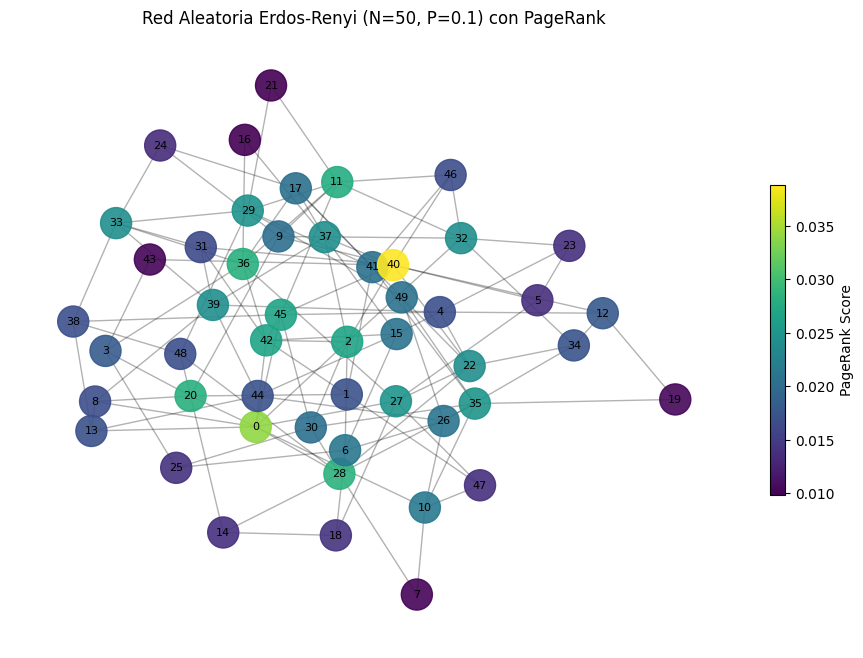

In [ ]:
# Celda 3: Código de Generación y Visualización

import cugraph
import cudf
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

# --- 1. Parámetros para la red Erdos-Renyi ---
# N = Número de nodos (vértices)
N = 50 # Un tamaño manejable para visualizar fácilmente
# P = Probabilidad de que exista una arista entre dos nodos
P = 0.1 # Ajusta esto para hacer la red más o menos densa

# --- 2. Generación de la red Erdos-Renyi con NetworkX (CPU) ---
# NetworkX es ideal para generar grafos sintéticos pequeños y luego convertirlos
G_nx = nx.erdos_renyi_graph(n=N, p=P, seed=42) # 'seed' para reproducibilidad

# --- 3. Convertir a formato cuGraph (GPU) ---
# Primero, extraemos las aristas de NetworkX en un DataFrame de cuDF
sources = [u for u, v in G_nx.edges()]
destinations = [v for u, v in G_nx.edges()]

# Si el grafo es pequeño y queremos todas las aristas
if not G_nx.edges(): # Manejar caso de grafo vacío
    print("El grafo Erdos-Renyi generado está vacío (quizás P es muy bajo o N muy pequeño).")
    # Crear un DataFrame vacío si no hay aristas
    edges_df = cudf.DataFrame({'source': cudf.Series(dtype=int), 'destination': cudf.Series(dtype=int)})
else:
    edges_df = cudf.DataFrame({
        'source': cudf.Series(sources, dtype=np.int32), # Asegúrate del tipo de dato
        'destination': cudf.Series(destinations, dtype=np.int32)
    })


# Crear el objeto grafo de cuGraph
G_cugraph = cugraph.Graph()
# Importante: para Erdos-Renyi, generalmente es no dirigido
G_cugraph.from_cudf_edgelist(edges_df, source='source', destination='destination', renumber=True)

# Después de renumber=True, los IDs de los vértices pueden cambiar.
# Obtén el mapeo si lo necesitas para la visualización posterior (si los IDs originales importan)
# Si no necesitas el mapeo, y solo visualizas los IDs re-numerados, no hay problema.

# --- 4. Aplicar un algoritmo de cuGraph (Ej: PageRank) ---
# El resultado es un DataFrame de cuDF con las columnas 'vertex' (id del nodo) y 'pagerank' (el valor).
pr_df = cugraph.pagerank(G_cugraph)

# --- 5. Preparar datos para visualización (convertir a CPU) ---
# cuGraph trabaja en GPU, NetworkX y Matplotlib en CPU. Necesitamos mover los datos.
# Convertir el grafo de cuGraph a NetworkX para visualización
# NOTA: Si el grafo es muy grande, esta conversión a CPU puede ser lenta o agotar la RAM.
# Para grafos pequeños (N=50-200), está bien.

# Convertir el DataFrame de aristas de cuDF a Pandas (CPU)
edges_pandas = edges_df.to_pandas()
G_nx_display = nx.Graph() # Crear un nuevo objeto NetworkX para visualizar
G_nx_display.add_edges_from(edges_pandas[['source', 'destination']].values)

# Preparar los puntajes de PageRank para colorear los nodos
# Asegurarse de que los IDs de los vértices coincidan entre pr_df y G_nx_display
pr_pandas = pr_df.to_pandas()
# Si se usó renumber=True en G_cugraph.from_cudf_edgelist, los IDs en pr_df son los re-numerados.
# Si G_nx_display se crea con los IDs originales, hay que mapearlos.
# Para este ejemplo simple, asumamos que los IDs coinciden o que los nuevos IDs son válidos para la visualización.
pr_dict = pr_pandas.set_index('vertex')['pagerank'].to_dict()

# Mapear los PageRank a los nodos del grafo para visualización
node_colors = [pr_dict.get(node, 0.0) for node in G_nx_display.nodes()]


# --- 6. Visualizar el grafo con Matplotlib ---
plt.figure(figsize=(10, 8))

# Posicionamiento de los nodos (layout)
pos = nx.spring_layout(G_nx_display, seed=42) # Usar el mismo seed para reproducibilidad visual

# Dibujar los nodos
# 'node_color' se basa en los valores de PageRank para colorear los nodos
# 'cmap' es el mapa de colores (ej. 'viridis', 'plasma', 'jet')
# 'vmin', 'vmax' establecen el rango de valores para el mapa de colores
nodes = nx.draw_networkx_nodes(G_nx_display, pos, node_color=node_colors, cmap=plt.cm.viridis,
                               node_size=500, alpha=0.9) # alpha es la transparencia

# Dibujar las aristas
nx.draw_networkx_edges(G_nx_display, pos, alpha=0.3, width=1.0)

# Dibujar las etiquetas de los nodos (IDs)
nx.draw_networkx_labels(G_nx_display, pos, font_size=8, font_color='black')

# Agregar una barra de color para la leyenda de PageRank
if nodes: # Asegurarse de que hay nodos para la barra de color
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                              norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([]) # Necesario para Matplotlib < 3.3
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('PageRank Score')

plt.title(f'Red Aleatoria Erdos-Renyi (N={N}, P={P}) con PageRank')
plt.axis('off') # Desactivar los ejes
plt.show()



In [ ]:
# Celda nueva para PyVis, otra visualización más interactiva.

from pyvis.network import Network
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np # Necesitamos numpy para verificar NaN

# Crear una red PyVis a partir del grafo NetworkX para interactividad
net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white", cdn_resources='local')

# Crear un mapa de colores normalizado para PageRank
node_colors_filtered = [c for c in node_colors if not np.isnan(c)] # Eliminar NaNs
if node_colors_filtered: # Asegurarse de que hay valores válidos para la normalización
    vmin = min(node_colors_filtered)
    vmax = max(node_colors_filtered)
    # Si todos los valores son iguales, ajusta vmax para evitar división por cero en Normalize
    if vmin == vmax:
        vmax = vmin + 1e-9 # Pequeño offset para evitar error de normalización
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.viridis
else: # Caso para un grafo vacío o sin nodos con PageRank válido
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = cm.viridis


# Añadir nodos y aristas al objeto PyVis
for node in G_nx_display.nodes():
    pr_score = pr_dict.get(node, 0.0) # Obtener PageRank

    # Manejar posibles NaNs en pr_score antes de normalizar
    if np.isnan(pr_score):
        hex_color = "#808080" # Un color gris si PageRank es NaN
    else:
        # Mapear el puntaje de PageRank a un color usando el mapa de colores
        rgba_color = cmap(norm(pr_score)) # Obtener color en formato RGBA (0-1)
        hex_color = mcolors.to_hex(rgba_color) # Convertir a formato HEX

    # La CLAVE está aquí: asegúrate de que 'node' sea un entero nativo de Python
    # Convertimos explícitamente el 'node' a int()
    net.add_node(int(node), label=str(node), title=f"Node {node} (PageRank: {pr_score:.4f})",
                 color=hex_color, value=float(pr_score)) # También convierte value a float para JSON

# Generar y mostrar el grafo interactivo
net.show("erdos_renyi_interactive.html")

# Para descargar el HTML generado (en mi caso no se pudo visualizar directamente en Colab, así que tocó descargarlo)
from google.colab import files
files.download("erdos_renyi_interactive.html")

erdos_renyi_interactive.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>